In [1]:
import numpy as np
import pandas as pd
import scipy
import nltk
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from nltk.stem.porter import *
import string
import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec
import sklearn
from sklearn.manifold import TSNE
from bokeh.io import output_notebook, output_file
%matplotlib inline
from bokeh.plotting import show, figure
import seaborn as sns

In [2]:
data=pd.read_csv("D:\\Work_folders\\datasets\\NLP - Project\\blogtext.csv")

In [3]:
data.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [4]:
data.loc[1]

id                                                  2059027
gender                                                 male
age                                                      15
topic                                               Student
sign                                                    Leo
date                                            13,May,2004
text                 These are the team members:   Drewe...
Name: 1, dtype: object

In [5]:
type(data["text"][1])

str

In [6]:
data["text"]=data["text"].str.lower()

In [7]:
data["text"]

0                    info has been found (+/- 100 pages,...
1                    these are the team members:   drewe...
2                    in het kader van kernfusie op aarde...
3                          testing!!!  testing!!!          
4                      thanks to yahoo!'s toolbar i can ...
                                ...                        
681279           dear susan,  i could write some really ...
681280           dear susan,  'i have the second yeast i...
681281           dear susan,  your 'boyfriend' is fuckin...
681282           dear susan:    just to clarify, i am as...
681283           hey everybody...and susan,  you might a...
Name: text, Length: 681284, dtype: object

In [8]:
data["topic"].unique()

array(['Student', 'InvestmentBanking', 'indUnk', 'Non-Profit', 'Banking',
       'Education', 'Engineering', 'Science', 'Communications-Media',
       'BusinessServices', 'Sports-Recreation', 'Arts', 'Internet',
       'Museums-Libraries', 'Accounting', 'Technology', 'Law',
       'Consulting', 'Automotive', 'Religion', 'Fashion', 'Publishing',
       'Marketing', 'LawEnforcement-Security', 'HumanResources',
       'Telecommunications', 'Military', 'Government', 'Transportation',
       'Architecture', 'Advertising', 'Agriculture', 'Biotech',
       'RealEstate', 'Manufacturing', 'Construction', 'Chemicals',
       'Maritime', 'Tourism', 'Environment'], dtype=object)

In [9]:
data["sign"].unique()

array(['Leo', 'Aquarius', 'Aries', 'Capricorn', 'Gemini', 'Cancer',
       'Sagittarius', 'Scorpio', 'Libra', 'Virgo', 'Taurus', 'Pisces'],
      dtype=object)

In [10]:
data["id"].is_unique

False

In [11]:
print("Total Number of Entries in the list : ",len(data["id"]))
print("Total number of unique bloggers:",len(data["id"].unique()))
print("At an average total number of posts attributed to each person is :", len(data["id"])/len(data["id"].unique()))

Total Number of Entries in the list :  681284
Total number of unique bloggers: 19320
At an average total number of posts attributed to each person is : 35.26314699792961


<AxesSubplot:xlabel='id', ylabel='Count'>

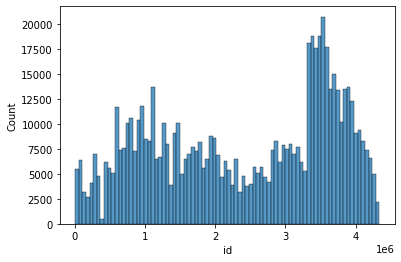

In [12]:
sns.histplot(x=data["id"])

<AxesSubplot:xlabel='topic', ylabel='Count'>

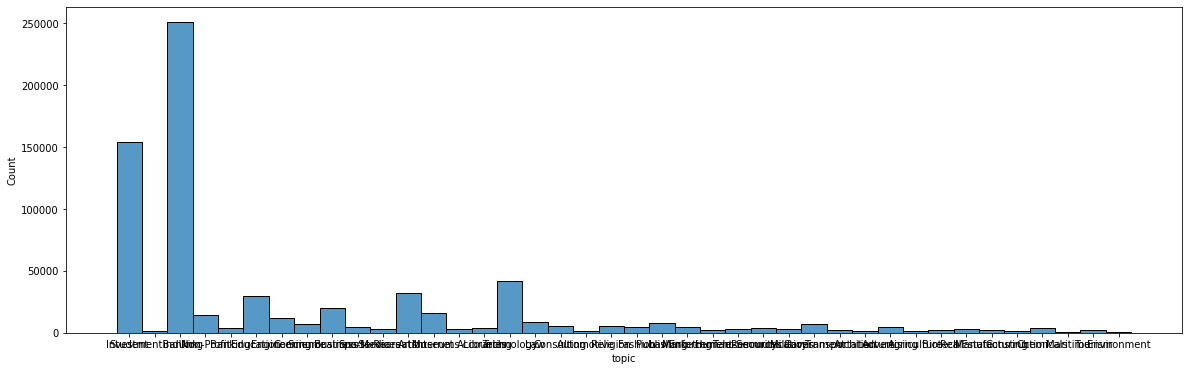

In [13]:
plt.figure(figsize=(20,6))
sns.histplot(data["topic"])

In [14]:
data["topic"].value_counts()

indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering                 11653
Law                          9040
Publishing                   7753
Science                      7269
Government                   6907
Consulting                   5862
Religion                     5235
Fashion                      4851
Marketing                    4769
Advertising                  4676
BusinessServices             4500
Banking                      4049
Chemicals                    3928
Telecommunications           3891
Accounting                   3832
Military                     3128
Museums-Libraries            3096
Sports-Recreation            3038
HumanResources               3010
RealEstate                   2870
Transportation               2326
Manufacturing 

In [15]:
t=data[data["id"]==data["id"].mode()[0]]
t


,id,gender,age,topic,sign,date,text
235798,449628,male,34,indUnk,Aries,"31,July,2002",update i've added links to other web...
235799,449628,male,34,indUnk,Aries,"25,July,2002",welcome to get that job! this is the...
235800,449628,male,34,indUnk,Aries,"30,August,2002",viva la library! your local public l...
235801,449628,male,34,indUnk,Aries,"29,August,2002",credential files: make your transcript...
235802,449628,male,34,indUnk,Aries,"23,August,2002",urllink university of cincinnati care...
...,...,...,...,...,...,...,...
240014,449628,male,34,indUnk,Aries,"01,August,2004",this past wednesday i went on an ...
240015,449628,male,34,indUnk,Aries,"01,August,2004",a parent wrote into the q&a forum...
240016,449628,male,34,indUnk,Aries,"01,August,2004","ireneq, the urllink official blog..."
240017,449628,male,34,indUnk,Aries,"01,August,2004",i often like to post to remind my...


In [16]:
data["id"].mode()

0    449628
dtype: int64

There is this one particular user with the id 449628 that has written so many blogposts i.e. 4221. Now, let us check what are all the topics that are being dealt with that particular user.

As the link provided in the problem statement indicates, there is one another topic that is repeating i.e. has maximum mode.

Let us now check how the longer posts are structured, whether they might carry any useful information for the sake of tokenization and classification. As usual, we need to have fixed size for Word vector Transformation. So, for that reason we will fix it to the maximum size once we are confirmed that we aren't missing out on a lot of data while we are dropping. Other dropping the outlier data, we have no other way to deal with classification material. Usually it is desirable to have retention of last certain number of words within the blog, as it contains summary of the whole blog and is likely to help in classification. For that matter, we need to have a close look at some of the longer posts to check if there is any kind of pattern to it, or any kind of way in which it can be salvaged.

So, lets dive in.


In [17]:
print(t.gender.unique())
print(t.age.unique())
print(t.topic.unique())

['male']
[34]
['indUnk']


In [18]:
k=data[data["topic"]=="Student"]
k

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",these are the team members: drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
97,3668238,female,17,Student,Gemini,"30,June,2004",http://www.uploadimages.net/i...
...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004","dear susan, i could write some really ..."
681280,1713845,male,23,Student,Taurus,"01,July,2004","dear susan, 'i have the second yeast i..."
681281,1713845,male,23,Student,Taurus,"01,July,2004","dear susan, your 'boyfriend' is fuckin..."
681282,1713845,male,23,Student,Taurus,"01,July,2004","dear susan: just to clarify, i am as..."


In [19]:
print(k.gender.unique())
print(k.age.unique())
print(k.id.value_counts())

['male' 'female']
[15 17 14 25 23 36 16 24 13 27 26 45 37 34 35 38 39 33 41 48 43 47 42]
1107146    2237
1784456    1843
955372     1771
988941     1542
780903     1337
           ... 
4294564       1
4140230       1
3866794       1
4291699       1
4173253       1
Name: id, Length: 5120, dtype: int64


In [20]:
k[k.id==k.id.value_counts().index[0]]

,id,gender,age,topic,sign,date,text
609212,1107146,female,16,Student,Libra,"02,July,2004","lindsey, we're 14, not thirteen. we're ..."
609213,1107146,female,16,Student,Libra,"02,July,2004",joah. god i hate you.
609214,1107146,female,16,Student,Libra,"02,July,2004",just for the record... rosie nor i said...
609215,1107146,female,16,Student,Libra,"02,July,2004",*laughs insanely* josh!! you had better...
609216,1107146,female,16,Student,Libra,"02,July,2004","ok, some ground rules... any of my inv..."
...,...,...,...,...,...,...,...
611444,1107146,female,16,Student,Libra,"26,July,2004",dudes. i would publish mine b...
611445,1107146,female,16,Student,Libra,"05,August,2004","as for the first one, certain..."
611446,1107146,female,16,Student,Libra,"04,August,2004","ok, so i was just thinking, a..."
611447,1107146,female,16,Student,Libra,"01,August,2004",well here you go; something ...


I have no idea what indUnk means but it seems to include a whole bunch of things that are not related. One single person, given by one single id, can't make 4221 posts. That's approximatley 11.5 years of atleast one post per day.

In [21]:
data["id"].mode()[0]

449628

Looks like 

In [22]:
temp=data["text"][15000]
print(temp)

             update!!! ran out of gas, so while its cooling down for refuel i come in to get a glass of tea and take some benadryl (the allergenic horrors out there!), and while sitting at my pc i see blood drops on my shirt, look at my wrist rest and find a blood stain pooling... somehow i cut my wrist open!! sooo, the count so far is 4 band-aids (3 to cover the length of the burn, 1 on the wrist)  before the day is through i will have used my entire neosporin tube and an entire box of band-aids, this i swear!         


In [23]:
r=[]
for each in data["text"]:
    r.append(len(each))
r=pd.Series(r)

<AxesSubplot:ylabel='Count'>

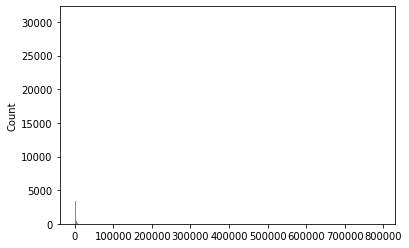

In [24]:
sns.histplot(r)

In [25]:
biggest_entry=data.iloc[r.nlargest(10).index[8]]
biggest_entry["text"]

"       ranted: june 11th 2004 feeling:sleepy well its 5 in the morning.. i spent most of my night crying over abused animals in slaughter houses.. yah i watched the videos.. for.. an hour.. and i was pretty upset.. ugh.. okay i cant keep typing about it i'll start crying again .. eh hem.. yes.. i have a feeling i wont be hanging out with stacey considering.. i've barely slept tonight..i also cant sleep because there was a huge spider in the bathroom and i woke up my mom to take it outside and when i came back it was gone.. and i was worried i was gonna fall asleep and have it crawl into my mouth or sit on it or something.. so i was half awake.. and then finally i fully woke up at 4 30.. and now here i am.. uggh im so fucking bored..a nd i wannna sleep because my eyes are burning but im too afraid. i donno how or wheni got so afraid of spiders.. but apparently im quite afraid of them..but yes.. bugs hate me.. they've been attacking me all night.. i have a huge bug bite on my back.. and

In [26]:
p=biggest_entry["text"].split(".")
p

['       ranted: june 11th 2004 feeling:sleepy well its 5 in the morning',
 '',
 ' i spent most of my night crying over abused animals in slaughter houses',
 '',
 ' yah i watched the videos',
 '',
 ' for',
 '',
 ' an hour',
 '',
 ' and i was pretty upset',
 '',
 ' ugh',
 '',
 " okay i cant keep typing about it i'll start crying again ",
 '',
 ' eh hem',
 '',
 ' yes',
 '',
 ' i have a feeling i wont be hanging out with stacey considering',
 '',
 " i've barely slept tonight",
 '',
 'i also cant sleep because there was a huge spider in the bathroom and i woke up my mom to take it outside and when i came back it was gone',
 '',
 ' and i was worried i was gonna fall asleep and have it crawl into my mouth or sit on it or something',
 '',
 ' so i was half awake',
 '',
 ' and then finally i fully woke up at 4 30',
 '',
 ' and now here i am',
 '',
 ' uggh im so fucking bored',
 '',
 'a nd i wannna sleep because my eyes are burning but im too afraid',
 ' i donno how or wheni got so afraid of spi

<AxesSubplot:ylabel='Density'>

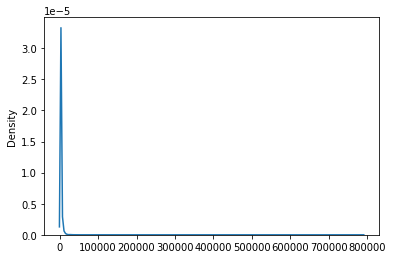

In [27]:
sns.kdeplot(r)

<AxesSubplot:>

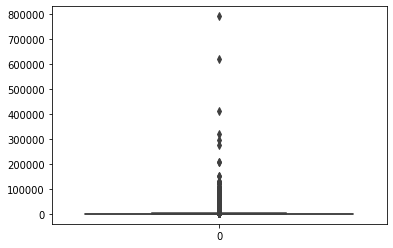

In [28]:
sns.boxplot(data=r)

In [67]:
r.describe()
df=data.loc[(r<r.describe()["75%"]) & (r>r.describe()["25%"])]

In [30]:
df.head()


,id,gender,age,topic,sign,date,text
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoo!'s toolbar i can ...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",somehow coca-cola has a way of su...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",i surf the english news sites a l...
13,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",there is so much that is differen...
16,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",urllink wonderful oh-gyup-sal...


In [31]:
c=r[r>r.describe()["75%"]]
c

2         25467
5          3695
7          2281
8          2289
10         1767
          ...  
681160     2787
681162     3462
681205     1569
681222     1716
681262     1634
Length: 170276, dtype: int64

<AxesSubplot:ylabel='Density'>

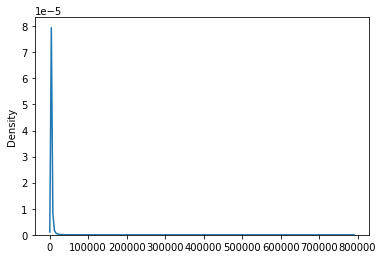

In [32]:
sns.kdeplot(c)

In [33]:
c.describe()

count    170276.000000
mean       2981.411297
std        4078.160082
min        1408.000000
25%        1751.000000
50%        2271.000000
75%        3279.000000
max      790123.000000
dtype: float64

In [34]:
c.nlargest(25)

529872    790123
302666    620448
658665    411850
31751     321278
384759    295127
632880    274796
465417    207704
589853    207078
401258    149736
275622    149709
466150    131862
632902    128462
103745    127355
440565    126168
649410    125024
205679    122228
192230    121862
16759     119813
576270    112846
112308    107585
668267    104801
592587    100146
282726     92889
597096     92820
612722     92767
dtype: int64

In [35]:
d=c[c>c.describe()["75%"]]
d

2         25467
5          3695
19         4521
27         5288
29         4778
          ...  
681014    10700
681016    16048
681025     4631
681128     3595
681162     3462
Length: 42549, dtype: int64

C:\Users\Sheshank_Joshi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

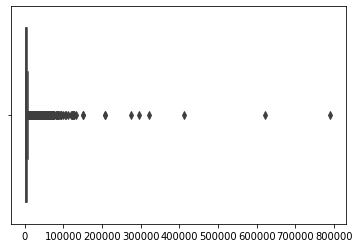

In [36]:
sns.boxplot(d)

In [37]:
d.nlargest(150)

529872    790123
302666    620448
658665    411850
31751     321278
384759    295127
           ...  
569888     34683
146349     34446
570033     34318
570034     34316
371874     34137
Length: 150, dtype: int64

In [38]:
e=d[d>d.describe()["75%"]]
e

2         25467
48        11101
219        9432
508       11182
577        6260
          ...  
680937    15983
680944    14248
680986    16061
681014    10700
681016    16048
Length: 10635, dtype: int64

C:\Users\Sheshank_Joshi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

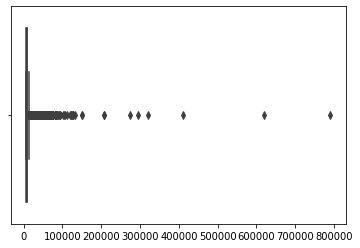

In [39]:
sns.boxplot(e)

In [40]:
e.describe()

count     10635.000000
mean      10017.670052
std       14072.682236
min        5879.000000
25%        6550.500000
50%        7638.000000
75%        9928.000000
max      790123.000000
dtype: float64

In [41]:
df_len=[]
for each in df.text:
    df_len.append(len(each))
df_len=pd.Series(df_len)

In [42]:
df_len.describe()

count    339930.000000
mean        694.070606
std         329.971156
min         231.000000
25%         405.000000
50%         637.000000
75%         951.000000
max        1406.000000
dtype: float64

So, after Examining, we can see that retaining is impossible with no general pattern for the blogs that had the data. Also, some of the entries were absolutely nothing and of no use, with no usable and meaningful entry. Those can be discarded too. So, we have minimum number of words to be 231 and maximum to be 1406.

From here we can start our word vector embedding. But there is a problem here. We have not taken out stop words or anything like that regarding punctuation and a whole bunch of other things. So, first we have to take them out and then start with all this analysis. So, for that we will take up the function that is already defined and taken up somewhere (respectfully copied from Kaggle and else where), and try to process it using that particular function.

In [43]:
nltk.download('stopwords')
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
 
stop_words = stopwords.words('english') + list(punctuation)
#print(punctuation)
def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sheshank_Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Plan**
The plan here thus is to to create a vector of the dimensions 1406.We then use it for classifier model of Sklearn. Before that we combine and create all the labels of a particular blog into one, and make a one hot encoding of that particular labels.



In [46]:
data.loc[45].text

"             this  urllink korea times business section editorial  speaks of jwa seung-hee's (president of an economic research institute for the federation of korean industries) 10 mysteries of the korean economy.  #1 western-style economic reform has eroded the dynamism of the korean economy.  #2 seoul has become bigger and bigger despite the government's policy of balanced regional development.  #3 the rural community's life has become dismal despite the policy of promoting the balanced development of the rural and urban communities.  #4 income disparity has widened despite the policy of promoting egalitarianism and redistributive policies.  #5 competitiveness of small companies has weakened despite the policy of curbing chaebol.  #6 economic concentration has deepened despite the policy to diffuse the concentration of economic power.  #7 the exodus of primary, middle and high school students for overseas study has increased as the government seeks to standardize schools.  #8 gover

In [47]:
tokens=tokenize(data.loc[45].text)
print(tokens)

['urllink', 'korea', 'times', 'business', 'section', 'editorial', 'speaks', 'jwa', 'seung-hee', "'s", 'president', 'economic', 'research', 'institute', 'federation', 'korean', 'industries', 'mysteries', 'korean', 'economy', 'western-style', 'economic', 'reform', 'eroded', 'dynamism', 'korean', 'economy', 'seoul', 'become', 'bigger', 'bigger', 'despite', 'government', "'s", 'policy', 'balanced', 'regional', 'development', 'rural', 'community', "'s", 'life', 'become', 'dismal', 'despite', 'policy', 'promoting', 'balanced', 'development', 'rural', 'urban', 'communities', 'income', 'disparity', 'widened', 'despite', 'policy', 'promoting', 'egalitarianism', 'redistributive', 'policies', 'competitiveness', 'small', 'companies', 'weakened', 'despite', 'policy', 'curbing', 'chaebol', 'economic', 'concentration', 'deepened', 'despite', 'policy', 'diffuse', 'concentration', 'economic', 'power', 'exodus', 'primary', 'middle', 'high', 'school', 'students', 'overseas', 'study', 'increased', 'govern

Looks like we have to run some Bigrams and trigrams across the text corups here. All the text columns, together here create the corpus.

In [48]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

bigram_finder = BigramCollocationFinder.from_words(tokens)
bigrams = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 50)

In [49]:
print(bigrams)

[('10-16', 'hours'), ('academies', 'n.i.m.f.t'), ('add', 'cultural'), ('always', 'compare'), ('amid', 'sloganeering'), ('another', 'interesting'), ('attitude', 'toward'), ('business', 'section'), ('business/economic', 'list'), ('child', 'restraint'), ('chung-hee', '’'), ('clean', 'air'), ('communities', 'income'), ('companies', 'weakened'), ('compare', 'foreigners'), ('control', 'finance'), ('created', 'miracle'), ('culture', 'may'), ('curbing', 'chaebol'), ('disparity', 'widened'), ('dog', 'another'), ('dogs', 'pets'), ('eat', 'dog'), ('editorial', 'speaks'), ('egalitarianism', 'redistributive'), ('erode', 'corporate'), ('eroded', 'dynamism'), ('exodus', 'primary'), ('family', 'tree'), ('financial', 'liberalization'), ('foreigners', 'rodeo'), ('friend', 'mine'), ('grandparents', 'insist'), ('hagwons', 'language'), ('han', 'river'), ('high', 'school'), ('hours', 'day'), ('income', 'disparity'), ('incredible', 'progress'), ('institute', 'federation'), ('interesting', 'story'), ('jwa', '

In [50]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer=WordNetLemmatizer()
tokens=word_tokenize(data.loc[45].text) #testing for one particular text

stemmed_tokens=[stemmer.stem(word) for word in tokens if word not in stop_words and not word.isdigit()]

In [51]:
stemmed_tokens

['urllink',
 'korea',
 'time',
 'busi',
 'section',
 'editori',
 'speak',
 'jwa',
 'seung-he',
 "'s",
 'presid',
 'econom',
 'research',
 'institut',
 'feder',
 'korean',
 'industri',
 'mysteri',
 'korean',
 'economi',
 'western-styl',
 'econom',
 'reform',
 'erod',
 'dynam',
 'korean',
 'economi',
 'seoul',
 'becom',
 'bigger',
 'bigger',
 'despit',
 'govern',
 "'s",
 'polici',
 'balanc',
 'region',
 'develop',
 'rural',
 'commun',
 "'s",
 'life',
 'becom',
 'dismal',
 'despit',
 'polici',
 'promot',
 'balanc',
 'develop',
 'rural',
 'urban',
 'commun',
 'incom',
 'dispar',
 'widen',
 'despit',
 'polici',
 'promot',
 'egalitarian',
 'redistribut',
 'polici',
 'competit',
 'small',
 'compani',
 'weaken',
 'despit',
 'polici',
 'curb',
 'chaebol',
 'econom',
 'concentr',
 'deepen',
 'despit',
 'polici',
 'diffus',
 'concentr',
 'econom',
 'power',
 'exodu',
 'primari',
 'middl',
 'high',
 'school',
 'student',
 'oversea',
 'studi',
 'increas',
 'govern',
 'seek',
 'standard',
 'school',

In [52]:
lemmatized_words=[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and not word.isdigit()]

In [63]:
stemmed_tokens=[stemmer.stem(word) for word in lemmatized_words if word not in stop_words and not word.isdigit()]
print(len(stemmed_tokens))

307


In [64]:
print(len(lemmatized_words))

307


In [54]:
lotr_pos_tags = nltk.pos_tag(lemmatized_words)

In [55]:
lotr_pos_tags

[('urllink', 'VB'),
 ('korea', 'JJ'),
 ('time', 'NN'),
 ('business', 'NN'),
 ('section', 'NN'),
 ('editorial', 'NN'),
 ('speaks', 'NNS'),
 ('jwa', 'VBP'),
 ('seung-hee', 'NN'),
 ("'s", 'POS'),
 ('president', 'NN'),
 ('economic', 'JJ'),
 ('research', 'NN'),
 ('institute', 'NN'),
 ('federation', 'NN'),
 ('korean', 'JJ'),
 ('industry', 'NN'),
 ('mystery', 'JJ'),
 ('korean', 'JJ'),
 ('economy', 'NN'),
 ('western-style', 'JJ'),
 ('economic', 'JJ'),
 ('reform', 'NN'),
 ('eroded', 'VBD'),
 ('dynamism', 'JJ'),
 ('korean', 'JJ'),
 ('economy', 'NN'),
 ('seoul', 'VBD'),
 ('become', 'JJ'),
 ('bigger', 'JJR'),
 ('bigger', 'JJR'),
 ('despite', 'IN'),
 ('government', 'NN'),
 ("'s", 'POS'),
 ('policy', 'NN'),
 ('balanced', 'VBD'),
 ('regional', 'JJ'),
 ('development', 'NN'),
 ('rural', 'JJ'),
 ('community', 'NN'),
 ("'s", 'POS'),
 ('life', 'NN'),
 ('become', 'VBN'),
 ('dismal', 'JJ'),
 ('despite', 'IN'),
 ('policy', 'NN'),
 ('promoting', 'VBG'),
 ('balanced', 'VBD'),
 ('development', 'NN'),
 ('rural',

In [56]:
nltk.download("maxent_ne_chunker")
nltk.download("words")
grammar = "NP: {<DT>?<JJ>*<NN>}"
#chunk_parser = nltk.RegexpParser(grammar)
#print(chunk_parser.parse(lotr_pos_tags))
tree = nltk.ne_chunk(lotr_pos_tags)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Sheshank_Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Sheshank_Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


https://realpython.com/nltk-nlp-python/

In [57]:
def extract_ne(quote):
    words = word_tokenize(quote, language="english")
    tags = nltk.pos_tag(words)
    tree = nltk.ne_chunk(tags, binary=True)
    return set(" ".join(i[0] for i in t) for t in tree if hasattr(t, "label") and t.label() == "NE")
    
extract_ne(data.loc[45].text)

{'u.s.'}

In [58]:
new_text=nltk.Text(lemmatized_words)
new_text.collocations() #Checking some collocations here.

despite policy; overseas study; development rural; n't seem; older
folk; policy promoting; many korean; korean economy; korea korean


In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer


def get_bigrams(tokens):
    from nltk.collocations import BigramCollocationFinder
    from nltk.metrics import BigramAssocMeasures

    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 500)

    for bigram_tuple in bigrams:
        x = "%s %s" % bigram_tuple
        tokens.append(x)

    result = [' '.join([w for w in x.split()]) for x in tokens if len(x) > 8]
    return result

In [61]:
get_bigrams(word_tokenize(data.loc[45].text))

['editorial',
 'seung-hee',
 'president',
 'institute',
 'federation',
 'industries',
 'mysteries',
 'western-style',
 'government',
 'development',
 'community',
 'promoting',
 'development',
 'communities',
 'disparity',
 'promoting',
 'egalitarianism',
 'redistributive',
 'competitiveness',
 'companies',
 'concentration',
 'concentration',
 'increased',
 'government',
 'standardize',
 'government',
 'sloganeering',
 'financial',
 'liberalization',
 'administration',
 'chung-hee',
 'development',
 'government',
 'strengthened',
 'corporate',
 'competitiveness',
 'business/economic',
 'mysteries',
 'grandparents',
 'academies',
 'n.i.m.f.t',
 'different',
 'especially',
 'incredible',
 'themselves',
 'foreigners',
 'especially',
 'katusa-korean',
 'vulnerable',
 'knowledge',
 'protective',
 'restraint',
 'seatbelts',
 'interesting',
 '10-16 hours',
 'always compare',
 'amid sloganeering',
 'another interesting',
 'any signals',
 'attitude toward',
 'business section',
 'business/econo

Now the path is clear here. It is described step by step here.

Step 1. Word Vectorize the Given text, considering each entry of the text column to be an individual file in the corpus of texts. Case Conversion is taken.


Step 2. Keep a word limit, decided by the length of the text column in use. So, the extremities i.e. very short texts and extremely long texts, that fall under the "outlier" category are eliminated. (Here the elimination of outliers happened before tokenization has been done because it doesn't make much difference either way because special characters are equally distributed across the text in proportion to their total size)


Step 3. Take out Part of Speech Tagging. Then go for RegexParser and Chunk the phrases into one single word in the word vectorizer. Create a finished list ready for reference.


Step 4. Lemmatize the word list, followed by stemming of the words to eliminate any probable repetetitions, or variations of the same root word. All the while excluding the words if they are in our reference word list.


Step 5 (skipped here). We check for any Concordance (which is skipped here), and also check for n-gram data for Qualitative analysis and summary. Though it is useful to see it, it is not being used here since here it is a simple classification problem.


Step 6. Either use CBOW or other glove method to convert it appropriate vector size.


Step 7. Club all the 

 

In [69]:
word_tokenize

AttributeError: module 'pandas' has no attribute 'join'

In [66]:
df.length

4         872.0
6         811.0
9         569.0
13        880.0
16        516.0
          ...  
681278      NaN
681279      NaN
681280      NaN
681282      NaN
681283      NaN
Name: length, Length: 339930, dtype: float64

In [198]:
class tfidf_vectors():
    
    ######################################################
    # Initializing the class function
    ######################################################
    
    def __init__(self,df_text_corpus):
        ############################################
        ############################################
        import nltk
        from string import punctuation
        from nltk.corpus import stopwords
        nltk.download('stopwords')
        self.stop_words = stopwords.words('english') + list(punctuation)
        ############################################
        ############################################
        self.corpus=df_text_corpus
        self.named_entities=[]
        self.vocabulary=[]
        self.word_index=None
        self.preprocess_token()
        self.vocabulary_build()
        self.tfidf=self.processing_vectorizer()
        
    ######################################################
    #End of Function
    ######################################################  

    ######################################################
    # Pre-Process to create tokens of the data.
    ######################################################
    def preprocess_token(self):
        from nltk import word_tokenize
        import string
        corpus_out=[]
        named_entities=[]
        for text in self.corpus:
            words = word_tokenize(text)
            words = [w.lower() for w in words]
            #print("----------------------")
            tokens = [w for w in words if w not in stop_words and not w.isdigit()]
            tokens = [w for w in tokens if any(c for c in w if c in string.ascii_letters)]
            #print(tokens)
            for t in tokens:
                #print(t)
                if type(t)!=str:
                    _=tokens.pop(t)
                    print(_)
            pure_tokens=self.preprocess_text(tokens)
            corpus_out.append(pure_tokens)
            #for t in pure_tokens:
                #print(t)
                #if type(t)!=str:
                    #_=tokens.pop(t)
                    #print(_)
            #print("\n\nHere\n\n")
            #print("----------------------")
            #print(pure_tokens)
            temp=list(self.extract_ne(tokens))
            #print("----------------------")
            #print("")
            #print("----------------------")
            if len(temp)!=0:
                named_entities.append(temp)
            else:
                temp=None
        self.named_entities=list(set(named_entities))
        #print("----------------------")
        #print("named_entities gathered")
        #print("----------------------")
        #print(self.named_entities)
        #print("----------------------")
        for word in named_entities:
            corpus_out.append(word)
        self.corpus=pd.Series(corpus_out)
        #print("----------------------")
        #print("self.corpus")
        #print("----------------------")
        #print(self.corpus)
    ######################################################
    # End of Function
    ######################################################

    ######################################################
    # Extracting Named Entities that lies in a list and is excepted from lemmatization and stemming
    ######################################################
    
    def extract_ne(self,text_tokens):
        ############################################
        ############################################
        import nltk
        ############################################
        ############################################
        tags = nltk.pos_tag(text_tokens)
        tree = nltk.ne_chunk(tags, binary=True)
        return set(" ".join(i[0] for i in t) for t in tree if hasattr(t, "label") and t.label() == "NE")

    ######################################################
    #End of Function
    ######################################################

    ######################################################
    # Proper Word conditioning with Lemmatization and Stemming
    ######################################################

    def preprocess_text(self,tokens): 
        ############################################
        ############################################
        from nltk.stem import PorterStemmer
        from nltk.stem import WordNetLemmatizer
        ############################################
        ############################################
        stemmer = PorterStemmer()
        lemmatizer=WordNetLemmatizer()
        lemmatized_words=[lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words and not word.isdigit()]
        stemmed_tokens=[stemmer.stem(word) for word in lemmatized_words]
        return stemmed_tokens
    
    ######################################################
    # End of Function
    ######################################################

    ######################################################
    # Building Vocabulary for tokenization so that proper vectors can be prepared.
    ######################################################

    def vocabulary_build(self):
        vocabulary = []
        for blog in self.corpus:
            #print("\n\nblog\n\n")
            for words in blog :
                if words not in vocabulary:
                    vocabulary.append(words)
        #print("----------------------")
        #print("printing Vocabulary")
        #print("----------------------")
        #print(vocabulary)
        for each_word in self.named_entities:
            print("----------------------")
            print("self.named_entities.each_word")
            print("----------------------")
            print(each_word)
            if each_word not in vocabulary:
                print("----------------------")
                print("new word added")
                print("----------------------")
                vocabulary.append(each_word)
        #print("----------------------")
        
        self.vocabulary=list(set(vocabulary))
        self.word_index = {w: index for index, w in enumerate(vocabulary)}
        #print("----------------------")
        #print("Printing self.word_index and self.vocabulary")
        #print("----------------------")
        #print(self.vocabulary)
        #print("----------------------")
        #print(self.word_index)
        print("The Length of the Vocabulary is :",len(self.vocabulary))
        print("The Number of Total Documents is :",len(self.corpus))
        
    ######################################################
    # End of Function
    ######################################################

    ######################################################
    # Model Fitting for TFIDF Vectorizer
    ######################################################
    
    def processing_vectorizer(self):
        ############################################
        ############################################  
        from sklearn.feature_extraction.text import TfidfVectorizer
        ############################################
        ############################################
        #print("----------------------")
        #print("self.corpus")
        #print("----------------------")
        #print(self.corpus)
        self.corpus=self.corpus.apply(lambda x: " ".join(x))
        tfidf = TfidfVectorizer()
        tfidf.fit(self.corpus)
        #print(k)
        #print("----------------------")
        #print(item for item in self.corpus)# if type(item)!=str)
        return tfidf
    
    ######################################################
    # End of Function
    ######################################################

    ######################################################
    # Vector Transformation of the inputs
    ######################################################
    
    def transform(self,text_tokens):
        if self.tfidf is not None:
            return self.tfidf.transform(text_tokens)
        else:
            raise AssertionError("Module not yet Trained")
    
    ######################################################
    # End of Function
    ######################################################
    
vect=tfidf_vectors(df.text[:10])

The Length of the Vocabulary is : 430
The Number of Total Documents is : 10


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sheshank_Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [200]:
vect.corpus[1]

"somehow coca-cola way sum thing well earli 1970 flagship jingl 'd like buy world coke tune 'd like teach world sing pretti much sum post-woodstock era well n't add much sale catchi tune korea coke 's theme urllink stop think feel pretti much sum lot korea korean look relax coupl stop think start feel cours high regard educ math logic deep think mani korean realli like work emot anyth els western seem sublim moreso least display differ way mayb scratch western korean probabl pretti similar context differ anyway think 're lose korea repeat 'stop think feel stop think feel stop think feel everyth alright"

In [183]:
y(["hello","world","program"])

'hello world program'

In [189]:
st=pd.Series(stemmed_tokens)
sr=st.apply(lambda x: x.split("l"))
sr

0      [ur, , ink]
1          [korea]
2           [time]
3           [busi]
4        [section]
          ...     
302      [unrea, ]
303        [thing]
304        [chang]
305        [thing]
306         [stay]
Length: 307, dtype: object

In [190]:
sr.apply(lambda x: " ".join(x))

0      ur  ink
1        korea
2         time
3         busi
4      section
        ...   
302     unrea 
303      thing
304      chang
305      thing
306       stay
Length: 307, dtype: object